In [2]:
# %matplotlib inline

from __future__ import annotations
from cycler import cycler
import json
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import shutil
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
import tensorflow.keras as keras
from typing import Callable, Literal

sns.set() # Use seaborn themes.

2022-12-04 17:52:29.668282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 17:52:32.265621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64:/lib/:/home/acd1797/.conda/envs/tf-gpu/lib/
2022-12-04 17:52:32.265743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [3]:
# Here define some root paths for saving content.
roots = dict(
    dataset = Path('./dataset/'),
    images = Path('./images/'),
    tuning = Path('./tuning/'),
)
for k,r in roots.items(): # Create directories if they do not already exist.
    if not r.exists():
        r.mkdir(exist_ok=True)

In [12]:
def load_trained_model(
    checkpoint_path: str,
    ) -> tuple[keras.models.Model]:
    """Helper to load a saved model."""
    model = keras.models.load_model(
        checkpoint_path,
        custom_objects=keras.utils.get_custom_objects(),
    )
    return model


def load_history(history_path: str):
    """Load model history from file."""
    return pd.read_csv(history_path)


def hypertune_load_history(tuning_root: Path) -> list[pd.DataFrame]:
    # Load parameter grid so that we know how many models there are.
    parameter_grid_path = tuning_root/'parameter_grid.json'
    with open(parameter_grid_path, 'r') as f:
        grid = json.load(f)

    # Iterate over parameter grid to load history for each model in the correct order.
    histories: list[list[pd.DataFrame]] = [] # History lists for each model.
    for i, p in enumerate(grid):
        cur_model_name = f"model_{i}"
        history_path = tuning_root/f"{cur_model_name}_history.csv"
        hist = load_history(history_path)
        histories.append(hist)
    return histories

In [5]:
tuning_root = roots['tuning']/"gan-hypertune"
histories = hypertune_load_history(tuning_root)

In [6]:
histories[0].head()

,epoch,d_accuracy,d_loss,g_accuracy,g_loss,g_mse,loss,val_d_accuracy,val_d_loss,val_g_accuracy,val_g_loss,val_g_mse,val_loss
0,0,0.750086,20.212833,0.162676,2.787466,0.163027,11.500150,0.000000,3.848210,0.048839,2.732713,0.236527,3.290461
1,1,0.782929,7.554433,0.126665,2.155943,0.274054,4.855188,0.287285,1.314022,0.104591,2.131450,0.180038,1.722736
2,2,0.879350,9.079504,0.048779,3.450586,0.277940,6.265045,0.230230,2.654163,0.123409,3.634990,0.137055,3.144577
3,3,0.935870,5.313097,0.031573,3.272716,0.277990,4.292906,0.241706,2.702956,0.008946,3.401550,0.219423,3.052253
4,4,0.924646,4.393957,0.037460,3.655999,0.292703,4.024978,0.234116,3.820737,0.104760,3.881640,0.193627,3.851189


In [7]:
def plot_with_errorbar(
    x: np.ndarray,
    y_line: np.ndarray,
    y_error_low: np.ndarray,
    y_error_high: np.ndarray,
    axis: plt.Axes,
    label: str = None,
    plotkwargs: dict = {},
    errorkwargs: dict = {},
    **kwargs,
    ):
    axis.plot(x, y_line, marker='.', markerfacecolor='white', label=label, **plotkwargs, **kwargs)
    axis.fill_between(x=x, y1=y_error_low, y2=y_error_high, alpha=0.2, **errorkwargs, **kwargs)


def plot_history_metric(
    histories: list[pd.DataFrame],
    metric: str,
    trace_idx: int,
    axis: plt.Axes,
    x_key: str = 'epoch',
    label: str = None,
    plotkwargs: dict = {},
    errorkwargs: dict = {},
    **kwargs,
    ):
    x = histories[0][x_key]
    y = np.array([h[metric].to_numpy() for h in histories])
    y_min = np.min(y, axis=0)
    y_max = np.max(y, axis=0)
    y_best = histories[trace_idx][metric].to_numpy()
    plot_with_errorbar(
        x=x,
        y_line=y_best,
        y_error_low=y_min,
        y_error_high=y_max,
        axis=axis,
        label=label,
        plotkwargs=plotkwargs,
        errorkwargs=errorkwargs,
        **kwargs,
    )

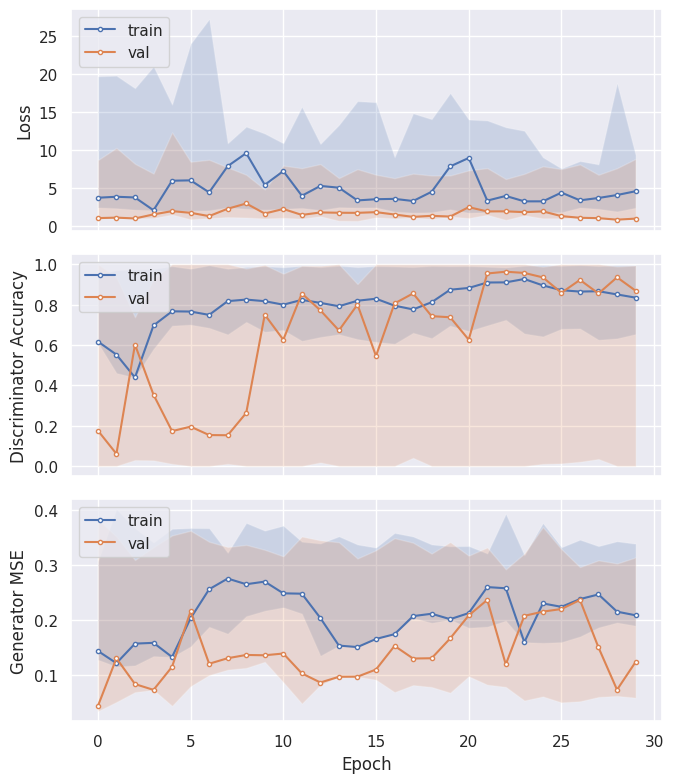

In [8]:
best_idx = np.argmin([h[f'val_loss'].iloc[-1] for h in histories])

fig, axd = plt.subplot_mosaic("A;B;C", figsize=(7,8), sharex=True, constrained_layout=True)

key = 'A'
plot_history_metric(histories, 'loss', trace_idx=best_idx, label='train', axis=axd[key])
plot_history_metric(histories, 'val_loss', trace_idx=best_idx, label='val', axis=axd[key])
axd[key].set_ylabel('Loss')
axd[key].legend(loc='upper left')

key = 'B'
plot_history_metric(histories, 'd_accuracy', trace_idx=best_idx, label='train', axis=axd[key])
plot_history_metric(histories, 'val_d_accuracy', trace_idx=best_idx, label='val', axis=axd[key])
axd[key].set_ylabel('Discriminator Accuracy')
axd[key].legend(loc='upper left')

key = 'C'
plot_history_metric(histories, 'g_mse', trace_idx=best_idx, label='train', axis=axd[key])
plot_history_metric(histories, 'val_g_mse', trace_idx=best_idx, label='val', axis=axd[key])
axd[key].set_ylabel('Generator MSE')
axd[key].legend(loc='upper left')

axd['C'].set_xlabel('Epoch')

fig.tight_layout()
fig.savefig(roots['images']/'gan_hypertune_metrics.png')

In [13]:
best_model_path = tuning_root/f"model_{best_idx}"
model = load_trained_model(best_model_path)
model.summary()

model.discriminator.summary()
model.generator.summary()

Model: "binary_gan_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator (Sequential)  (None, 24, 1)             9241      
                                                                 
 generator (Sequential)      (None, 24, 2)             29138     
                                                                 
Total params: 38,385
Trainable params: 38,379
Non-trainable params: 6
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU_0 (GRU)                 (None, 24, 24)            2016      
                                                                 
 GRU_1 (GRU)                 (None, 24, 24)            3600      
                                                                 
 GRU_2 (GRU)               